In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost
from utils import get_data, amex_metric
import ipywidgets


plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [2]:
CFG = {
    'num_folds': 5,

    'catboost': {
        'depth': 6,
        'iterations': 4000,
        'learning_rate': 0.04,
    },

    'seed': 777
}

In [3]:
train_data, target, cat_features = get_data('data/train_data.ftr', train=True)

/Users/dmitrykutsenko/Desktop/My_python/Kaggle_amex/utils.py:77: FutureWarning: ['S_2', 'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  main_data = data.drop('target', axis=1).groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()


In [5]:
model = CatBoostClassifier(
    depth=CFG['catboost']['depth'],
    iterations=2000,
    #learning_rate=CFG['catboost']['learning_rate'],
    custom_metric='AUC',
    random_seed=CFG['seed'],
    thread_count=6,
    early_stopping_rounds=300
)
features = [f for f in train_data.columns if f not in ('customer_ID', 'target')]
model.fit(Pool(train_data[features], target, cat_features=cat_features), verbose=100)

Learning rate set to 0.074722
0:	learn: 0.6031589	total: 519ms	remaining: 17m 17s
100:	learn: 0.2268033	total: 38.1s	remaining: 11m 55s
200:	learn: 0.2200526	total: 1m 12s	remaining: 10m 52s
300:	learn: 0.2156306	total: 1m 50s	remaining: 10m 21s
400:	learn: 0.2122245	total: 2m 25s	remaining: 9m 39s
500:	learn: 0.2092379	total: 2m 59s	remaining: 8m 57s
600:	learn: 0.2063932	total: 3m 34s	remaining: 8m 19s
700:	learn: 0.2037983	total: 4m 8s	remaining: 7m 41s
800:	learn: 0.2013659	total: 4m 42s	remaining: 7m 2s
900:	learn: 0.1990368	total: 5m 16s	remaining: 6m 26s
1000:	learn: 0.1966388	total: 5m 50s	remaining: 5m 49s
1100:	learn: 0.1943606	total: 6m 25s	remaining: 5m 14s
1200:	learn: 0.1921247	total: 6m 59s	remaining: 4m 39s
1300:	learn: 0.1899643	total: 7m 34s	remaining: 4m 3s
1400:	learn: 0.1878774	total: 8m 8s	remaining: 3m 28s
1500:	learn: 0.1857664	total: 8m 42s	remaining: 2m 53s
1600:	learn: 0.1837301	total: 9m 16s	remaining: 2m 18s
1700:	learn: 0.1817463	total: 9m 50s	remaining: 1

In [6]:
feature_imp = model.get_feature_importance()
bad_cols = [features[i] for i in range(len(features)) if feature_imp[i] < 0.03]
train_data.drop(bad_cols, axis=1, inplace=True)
cat_features = [x for x in cat_features if x in train_data.columns.tolist()]

with open('models/feature_list.pkl', 'wb') as f:
    pickle.dump([train_data.columns.tolist(), cat_features], f)

In [7]:
train_data

,B_1_last,B_10_last,B_11_last,B_15_last,B_17_last,B_18_last,B_19_last,B_2_last,B_20_last,B_22_last,...,D_136_std,D_138_max,D_139_std,D_140_mean,D_140_min,D_140_max,D_141_max,D_142_std,D_144_std,D_145_median
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.009384,0.326172,0.010262,0.014549,NaN,1.007812,0.005276,1.007812,0.007629,0.008049,...,NaN,NaN,0.002616,0.005341,0.001976,0.009605,0.009384,NaN,0.002598,0.006363
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.034698,0.297119,0.014572,0.009537,NaN,1.003906,0.008049,1.003906,0.004318,0.006172,...,NaN,NaN,0.003068,0.006271,0.001808,0.009377,0.009880,NaN,0.002871,0.004471
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.004284,0.296387,0.005093,0.006031,NaN,1.003906,0.005951,0.812500,0.002834,0.002794,...,NaN,NaN,0.002782,0.004677,0.000304,0.009544,0.009346,NaN,0.003638,0.005112
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.012566,0.411621,0.005489,0.002199,1.007812,1.006836,0.007713,1.005859,0.008560,0.000993,...,NaN,NaN,0.002462,0.005779,0.000461,0.009735,0.008865,NaN,0.002654,0.006355
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.007679,0.125244,0.001000,0.005840,NaN,0.531250,0.006706,0.815918,0.008804,0.009727,...,NaN,NaN,0.002858,0.004818,0.000686,0.009186,0.008698,NaN,0.002634,0.002884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.028519,0.436035,0.024429,0.004768,NaN,1.001953,0.002272,1.009766,0.000525,0.007317,...,NaN,NaN,0.002777,0.005699,0.001381,0.009941,0.009659,NaN,0.003264,0.005592
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.292480,0.021011,0.233765,0.009941,0.860840,0.098267,0.750488,0.055664,1.000977,0.003843,...,NaN,NaN,0.002863,0.003799,0.000167,0.009613,0.009674,NaN,0.002826,0.006187
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.020569,0.302734,0.010727,0.007996,0.228394,1.002930,0.002565,1.006836,0.006031,0.003168,...,NaN,NaN,0.002983,0.003859,0.000498,0.009232,0.009224,NaN,0.002944,0.003502
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461,0.015839,0.035461,0.002506,0.002916,0.737305,0.465088,0.008972,0.714355,0.180420,0.009460,...,NaN,NaN,0.002815,0.006763,0.003937,0.009964,0.949707,0.015793,0.002728,0.185791


In [9]:
score_list = []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr, X_va = train_data.iloc[idx_tr], train_data.iloc[idx_va]
    y_tr, y_va = target.iloc[idx_tr], target.iloc[idx_va]
    
    model = CatBoostClassifier(
        depth=CFG['catboost']['depth'],
        iterations=CFG['catboost']['iterations'],
        learning_rate=CFG['catboost']['learning_rate'],
        # custom_metric=['AUC'],
        # eval_metric=['AUC'],
        random_seed=CFG['seed'],
        thread_count=6,
        early_stopping_rounds=300
    )
    
    model.fit(Pool(X_tr, y_tr, cat_features=cat_features),
              eval_set=Pool(X_va, y_va, cat_features=cat_features),
              verbose=100, plot=True)
    model.save_model(f'models/catboost_{fold}.cbm')

    y_va_pred = model.predict_proba(Pool(X_va, cat_features=cat_features))[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    gc.collect()

print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6450907	test: 0.6449548	best: 0.6449548 (0)	total: 246ms	remaining: 16m 24s
100:	learn: 0.2349713	test: 0.2336171	best: 0.2336171 (100)	total: 17.6s	remaining: 11m 19s
200:	learn: 0.2261139	test: 0.2256506	best: 0.2256506 (200)	total: 34.7s	remaining: 10m 55s
300:	learn: 0.2219343	test: 0.2225346	best: 0.2225346 (300)	total: 51.8s	remaining: 10m 36s
400:	learn: 0.2187264	test: 0.2205970	best: 0.2205970 (400)	total: 1m 8s	remaining: 10m 14s
500:	learn: 0.2160152	test: 0.2193885	best: 0.2193885 (500)	total: 1m 25s	remaining: 9m 56s
600:	learn: 0.2137466	test: 0.2185921	best: 0.2185921 (600)	total: 1m 41s	remaining: 9m 36s
700:	learn: 0.2116545	test: 0.2180013	best: 0.2180013 (700)	total: 1m 58s	remaining: 9m 18s
800:	learn: 0.2097413	test: 0.2175611	best: 0.2175574 (799)	total: 2m 14s	remaining: 8m 58s
900:	learn: 0.2078982	test: 0.2172504	best: 0.2172504 (900)	total: 2m 31s	remaining: 8m 39s
1000:	learn: 0.2060939	test: 0.2169725	best: 0.2169725 (1000)	total: 2m 47s	remainin

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6436074	test: 0.6437571	best: 0.6437571 (0)	total: 238ms	remaining: 15m 53s
100:	learn: 0.2340304	test: 0.2360874	best: 0.2360874 (100)	total: 17.7s	remaining: 11m 24s
200:	learn: 0.2254476	test: 0.2284158	best: 0.2284158 (200)	total: 34.4s	remaining: 10m 50s
300:	learn: 0.2213874	test: 0.2253876	best: 0.2253876 (300)	total: 51.3s	remaining: 10m 31s
400:	learn: 0.2182126	test: 0.2235310	best: 0.2235310 (400)	total: 1m 7s	remaining: 10m 7s
500:	learn: 0.2155464	test: 0.2223911	best: 0.2223911 (500)	total: 1m 24s	remaining: 9m 49s
600:	learn: 0.2132404	test: 0.2216506	best: 0.2216506 (600)	total: 1m 40s	remaining: 9m 29s
700:	learn: 0.2111171	test: 0.2211064	best: 0.2211064 (700)	total: 1m 57s	remaining: 9m 11s
800:	learn: 0.2091341	test: 0.2207288	best: 0.2207288 (800)	total: 2m 13s	remaining: 8m 54s
900:	learn: 0.2073285	test: 0.2204694	best: 0.2204690 (893)	total: 2m 29s	remaining: 8m 35s
1000:	learn: 0.2055519	test: 0.2202793	best: 0.2202793 (1000)	total: 2m 46s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6437604	test: 0.6436847	best: 0.6436847 (0)	total: 275ms	remaining: 18m 18s
100:	learn: 0.2343294	test: 0.2345961	best: 0.2345961 (100)	total: 17.6s	remaining: 11m 19s
200:	learn: 0.2258488	test: 0.2267498	best: 0.2267498 (200)	total: 34.6s	remaining: 10m 53s
300:	learn: 0.2218287	test: 0.2235191	best: 0.2235191 (300)	total: 51.2s	remaining: 10m 29s
400:	learn: 0.2187067	test: 0.2215226	best: 0.2215226 (400)	total: 1m 7s	remaining: 10m 7s
500:	learn: 0.2161246	test: 0.2203428	best: 0.2203428 (500)	total: 1m 24s	remaining: 9m 49s
600:	learn: 0.2138014	test: 0.2194262	best: 0.2194262 (600)	total: 1m 40s	remaining: 9m 30s
700:	learn: 0.2116850	test: 0.2187673	best: 0.2187673 (700)	total: 1m 57s	remaining: 9m 11s
800:	learn: 0.2097502	test: 0.2182253	best: 0.2182253 (800)	total: 2m 13s	remaining: 8m 54s
900:	learn: 0.2079085	test: 0.2178964	best: 0.2178964 (900)	total: 2m 30s	remaining: 8m 36s
1000:	learn: 0.2061147	test: 0.2176373	best: 0.2176346 (998)	total: 2m 46s	remaining:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6427746	test: 0.6428485	best: 0.6428485 (0)	total: 253ms	remaining: 16m 50s
100:	learn: 0.2341888	test: 0.2353844	best: 0.2353844 (100)	total: 18.2s	remaining: 11m 42s
200:	learn: 0.2256236	test: 0.2278001	best: 0.2278001 (200)	total: 35.1s	remaining: 11m 3s
300:	learn: 0.2215350	test: 0.2248529	best: 0.2248529 (300)	total: 51.9s	remaining: 10m 37s
400:	learn: 0.2182745	test: 0.2229006	best: 0.2229006 (400)	total: 1m 8s	remaining: 10m 16s
500:	learn: 0.2156155	test: 0.2217760	best: 0.2217760 (500)	total: 1m 25s	remaining: 9m 56s
600:	learn: 0.2132781	test: 0.2209471	best: 0.2209471 (600)	total: 1m 42s	remaining: 9m 38s
700:	learn: 0.2111648	test: 0.2204297	best: 0.2204297 (700)	total: 1m 58s	remaining: 9m 19s
800:	learn: 0.2091904	test: 0.2200246	best: 0.2200226 (799)	total: 2m 15s	remaining: 9m
900:	learn: 0.2073524	test: 0.2197671	best: 0.2197629 (893)	total: 2m 32s	remaining: 8m 42s
1000:	learn: 0.2055456	test: 0.2194600	best: 0.2194587 (999)	total: 2m 48s	remaining: 8m 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6432721	test: 0.6434590	best: 0.6434590 (0)	total: 244ms	remaining: 16m 15s
100:	learn: 0.2338184	test: 0.2370069	best: 0.2370069 (100)	total: 17.9s	remaining: 11m 32s
200:	learn: 0.2251647	test: 0.2294751	best: 0.2294751 (200)	total: 34.9s	remaining: 10m 59s
300:	learn: 0.2209929	test: 0.2263528	best: 0.2263528 (300)	total: 51.3s	remaining: 10m 30s
400:	learn: 0.2177687	test: 0.2244474	best: 0.2244474 (400)	total: 1m 8s	remaining: 10m 10s
500:	learn: 0.2150979	test: 0.2234256	best: 0.2234256 (500)	total: 1m 24s	remaining: 9m 52s
600:	learn: 0.2127661	test: 0.2226030	best: 0.2226030 (600)	total: 1m 41s	remaining: 9m 33s
700:	learn: 0.2106733	test: 0.2221355	best: 0.2221355 (700)	total: 1m 57s	remaining: 9m 13s
800:	learn: 0.2087366	test: 0.2217319	best: 0.2217311 (799)	total: 2m 13s	remaining: 8m 55s
900:	learn: 0.2069146	test: 0.2214095	best: 0.2214059 (899)	total: 2m 30s	remaining: 8m 36s
1000:	learn: 0.2050817	test: 0.2211669	best: 0.2211669 (1000)	total: 2m 46s	remainin

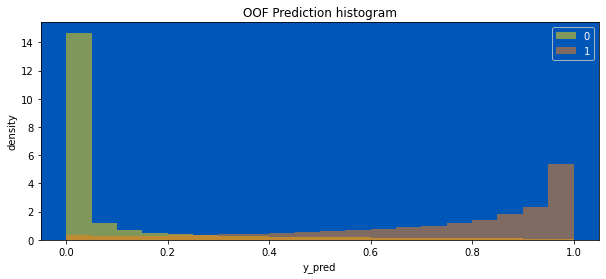

In [10]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

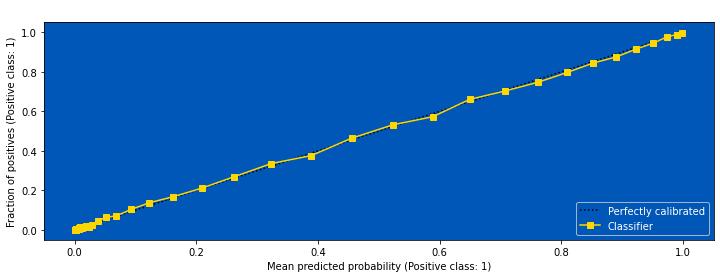

In [11]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()